# ST 590-651 Project 2 Part 2: Northwind Data Analysis

*Performed by Group G: Raiden Han, Jingjing Li, Nataliya Peshekhodko*

*06/27/2022*

## Introduction and Module Preparation

This section will analyze the [Northwind sample database](https://github.com/jpwhite3/northwind-SQLite3) provided with Microsoft Access 2000 and from Github, using `SQLite3` and other Python modules.

![Northwind](images/Northwind_ERD.png)

To begin with, we will import the necessary modules and build a connection to the database.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Build a connection to the database
con = sqlite3.connect(r'data/northwind.sqlite')

## Data Integration and Analysis

Before performing any data analysis, we want to check the schema of the database to ensure that the tables contained in our database are consistent with the entity-relationship diagram above and to determine the integrity of the data.

In [2]:
pd.read_sql_query('''
    SELECT *
    FROM sqlite_schema
    WHERE type = 'table';
    ''', con)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
3,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
4,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
7,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
8,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
9,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...


Next, we will analyze the above tables in combination.

### Employees & Orders

First, we will merge the employee form with the order form to get an overview of each employee's order information. In particular, we will keep the order date and freight and calculate the shipping time and the number of early arrival days.

In [3]:
employee_order = pd.read_sql_query('''
    SELECT e.EmployeeID, e.FirstName, e.LastName, 
    o.OrderID, o.orderDate, o.Freight, 
    JULIANDAY(o.ShippedDate) - JULIANDAY(o.OrderDate) AS ShippingDay, 
    JULIANDAY(o.RequiredDate) - JULIANDAY(o.ShippedDate) AS EarlyDay
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID;
    ''', con)
employee_order.head()

,EmployeeID,FirstName,LastName,OrderID,OrderDate,Freight,ShippingDay,EarlyDay
0,5,Steven,Buchanan,10248,1996-07-04 00:00:00.000,32.38,12.0,16.0
1,6,Michael,Suyama,10249,1996-07-05 00:00:00.000,11.61,5.0,37.0
2,4,Margaret,Peacock,10250,1996-07-08 00:00:00.000,65.83,4.0,24.0
3,3,Janet,Leverling,10251,1996-07-08 00:00:00.000,41.34,7.0,21.0
4,4,Margaret,Peacock,10252,1996-07-09 00:00:00.000,51.30,2.0,26.0


We will aggregate the total number of orders for each employee in our database and sort them in descending order.

In [4]:
tope = pd.read_sql_query('''
    SELECT e.EmployeeID, e.FirstName, e.LastName, COUNT(*) AS OrderCount
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    GROUP BY e.EmployeeID
    ORDER BY OrderCount DESC
    ''', con)
tope

,EmployeeID,FirstName,LastName,OrderCount
0,4,Margaret,Peacock,156
1,3,Janet,Leverling,127
2,1,Nancy,Davolio,123
3,8,Laura,Callahan,104
4,2,Andrew,Fuller,96
5,7,Robert,King,72
6,6,Michael,Suyama,67
7,9,Anne,Dodsworth,43
8,5,Steven,Buchanan,42


The table above shows a large variation in the number of orders completed by individual employees in the company. Margaret Peacock has the highest number of orders at 156, while Steven Buchanan has the lowest number of orders at 42.

To better understand how the number of orders per employee changes over time, we will summarize the number of orders per employee on a six-month cycle and draw a line graph.

In [5]:
# Convert the OrderDate column to the TimeStamp data type
employee_order['OrderDate'] = pd.to_datetime(employee_order['OrderDate'])
# Count the half-year order numbers grouped by employees
order_count_time = employee_order.groupby(
    ['EmployeeID', 'FirstName', 'LastName']).resample(
    '2QS', on='OrderDate').count().iloc[:, 0].rename(
    'OrderCount').reset_index()
order_count_time.head()

,EmployeeID,FirstName,LastName,OrderDate,OrderCount
0,1,Nancy,Davolio,1996-07-01,26
1,1,Nancy,Davolio,1997-01-01,20
2,1,Nancy,Davolio,1997-07-01,35
3,1,Nancy,Davolio,1998-01-01,42
4,2,Andrew,Fuller,1996-07-01,16


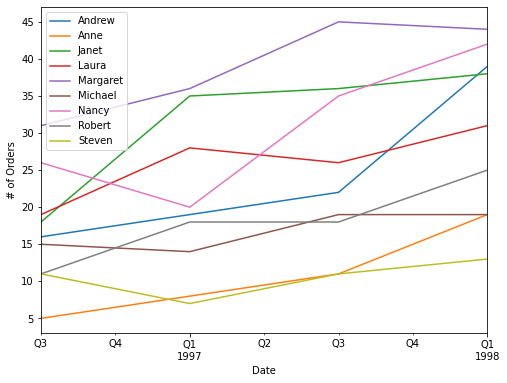

In [6]:
# Set the date as index
order_count_time.set_index('OrderDate', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
order_count_time.groupby('FirstName')['OrderCount'].plot(ax=ax, legend=True)
ax.set_xlabel('Date')
ax.set_ylabel('# of Orders')
plt.show()

The line graph above reveals an important piece of information: the order data for all employees starts at approximately the same time. As time passes, the number of orders for each employee shows an upward trend, but the level does not change significantly. Also, the graph shows that Margaret has the most orders and Steven has the least orders, which is consistent with the previously described results.

In [7]:
employee_order.groupby('FirstName')['Freight'].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,96.0,90.587604,142.054368,0.17,11.4225,45.560,92.7575,810.05
Anne,43.0,77.354884,128.135494,0.48,12.2550,30.850,93.3000,754.26
Janet,127.0,85.706614,146.117021,0.14,12.3700,43.900,90.4900,1007.64
Laura,104.0,71.998846,82.756930,0.33,12.5500,38.485,104.6925,398.36
Margaret,156.0,72.731667,103.157357,0.02,14.7000,42.965,81.8875,719.78
Michael,67.0,56.424925,74.193019,0.12,6.7000,27.330,71.0350,367.63
Nancy,123.0,71.842602,82.424136,0.21,21.6950,44.150,95.0300,544.08
Robert,72.0,92.575556,140.633406,0.40,16.4175,42.005,90.1700,830.75
Steven,42.0,93.302619,153.469722,0.59,15.7500,41.745,122.7825,890.78


In [8]:
employee_order.groupby('FirstName')['ShippingDay'].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,93.0,8.053763,6.182664,1.0,4.00,7.0,10.00,32.0
Anne,42.0,10.857143,8.623766,1.0,6.25,7.0,10.75,34.0
Janet,127.0,8.425197,6.788786,1.0,5.00,7.0,9.00,35.0
Laura,100.0,8.680000,7.821080,1.0,4.00,6.0,9.25,37.0
Margaret,151.0,8.821192,6.978143,1.0,5.00,7.0,10.00,35.0
Michael,65.0,9.092308,7.242934,1.0,5.00,7.0,10.00,32.0
Nancy,120.0,7.758333,5.562473,1.0,4.00,6.5,9.00,34.0
Robert,69.0,8.376812,7.487443,1.0,4.00,7.0,9.00,37.0
Steven,42.0,7.023810,4.279777,1.0,4.25,6.5,9.00,25.0


In [9]:
employee_order.groupby('FirstName')['EarlyDay'].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,93.0,19.344086,8.778054,-16.0,18.00,21.0,24.0,41.0
Anne,42.0,16.809524,11.828527,-17.0,8.75,21.0,23.0,37.0
Janet,127.0,19.133858,8.025121,-7.0,18.00,21.0,23.0,39.0
Laura,100.0,20.440000,9.995272,-9.0,18.00,22.0,25.0,39.0
Margaret,151.0,18.251656,8.662731,-18.0,16.50,21.0,23.5,34.0
Michael,65.0,19.338462,9.346251,-18.0,18.00,21.0,23.0,39.0
Nancy,120.0,19.775000,7.738871,-11.0,18.00,22.0,24.0,36.0
Robert,69.0,20.434783,9.540129,-23.0,19.00,22.0,25.0,36.0
Steven,42.0,20.976190,7.875520,-1.0,19.00,22.0,24.0,39.0


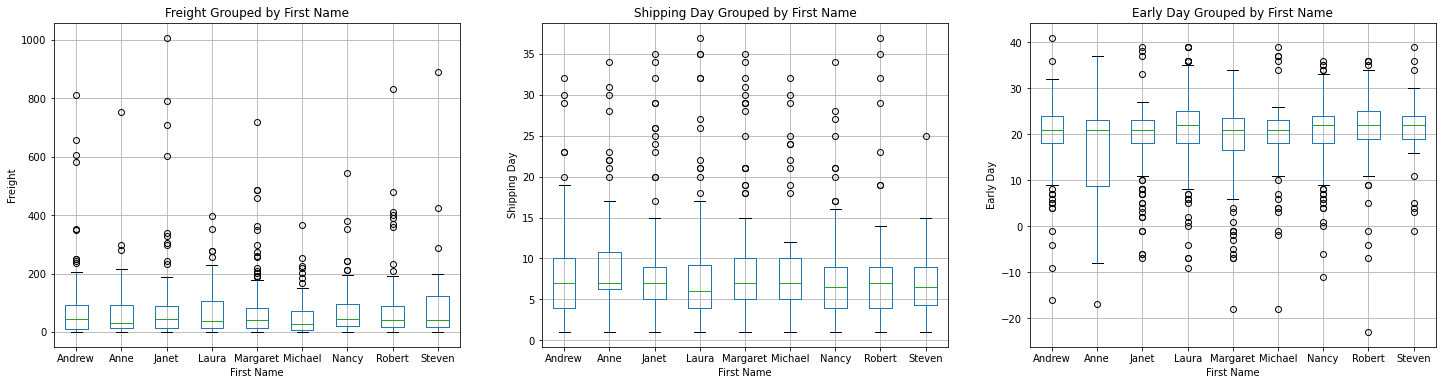

In [10]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=3, figsize=(24, 6))
# Create boxplots
employee_order.boxplot(column='Freight', by='FirstName', ax=ax[0])
employee_order.boxplot(column='ShippingDay', by='FirstName', ax=ax[1])
employee_order.boxplot(column='EarlyDay', by='FirstName', ax=ax[2])
# Add labels
ax[0].set_title('Freight Grouped by First Name')
ax[0].set_xlabel('First Name')
ax[0].set_ylabel('Freight')
ax[1].set_title('Shipping Day Grouped by First Name')
ax[1].set_xlabel('First Name')
ax[1].set_ylabel('Shipping Day')
ax[2].set_title('Early Day Grouped by First Name')
ax[2].set_xlabel('First Name')
ax[2].set_ylabel('Early Day')
plt.suptitle('')
# Show the image
plt.show()

### Employees & Product Details

In [11]:
employee_category = pd.read_sql_query("""
    SELECT e.EmployeeID, e.FirstName, e.LastName, c.CategoryName,
    od.OrderID, od.ProductID, od.UnitPrice, od.Quantity
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    INNER JOIN "Order Details" od
    ON o.OrderID = od.OrderID
    INNER JOIN Products p 
    ON od.ProductID = p.ProductID
    INNER JOIN Categories c
    ON p.CategoryID = c.CategoryID
    """, con)
employee_category.head()

,EmployeeID,FirstName,LastName,CategoryName,OrderID,ProductID,UnitPrice,Quantity
0,5,Steven,Buchanan,Dairy Products,10248,11,14.0,12
1,5,Steven,Buchanan,Grains/Cereals,10248,42,9.8,10
2,5,Steven,Buchanan,Dairy Products,10248,72,34.8,5
3,6,Michael,Suyama,Produce,10249,14,18.6,9
4,6,Michael,Suyama,Produce,10249,51,42.4,40


In [12]:
employee_category['Value'] = employee_category[
    'UnitPrice'] * employee_category['Quantity']
employee_category.head()

,EmployeeID,FirstName,LastName,CategoryName,OrderID,ProductID,UnitPrice,Quantity,Value
0,5,Steven,Buchanan,Dairy Products,10248,11,14.0,12,168.0
1,5,Steven,Buchanan,Grains/Cereals,10248,42,9.8,10,98.0
2,5,Steven,Buchanan,Dairy Products,10248,72,34.8,5,174.0
3,6,Michael,Suyama,Produce,10249,14,18.6,9,167.4
4,6,Michael,Suyama,Produce,10249,51,42.4,40,1696.0


In [13]:
employee_cat_quantity_value = employee_category.groupby(
    ['FirstName', 'CategoryName']).agg({'Quantity': sum, 'Value': sum})
employee_cat_quantity_value.reset_index(inplace=True)
employee_cat_quantity_value.head()

,FirstName,CategoryName,Quantity,Value
0,Andrew,Beverages,1069,42029.40
1,Andrew,Condiments,709,16353.10
2,Andrew,Confections,863,21696.95
3,Andrew,Dairy Products,910,25594.70
4,Andrew,Grains/Cereals,645,12063.10


In [14]:
employee_cat_quantity_pivot = pd.pivot_table(
    employee_cat_quantity_value, 
    index='FirstName', columns='CategoryName', values='Quantity')
employee_cat_quantity_pivot.head()

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
FirstName,,,,,,,,
Andrew,1069,709,863,910,645,702,297,860
Anne,519,493,365,639,74,135,41,404
Janet,1310,670,1346,1308,887,525,327,1479
Laura,1308,634,989,726,688,419,411,738
Margaret,1572,1252,1535,1455,1000,921,558,1505


In [15]:
employee_cat_value_pivot = pd.pivot_table(
    employee_cat_quantity_value, 
    index='FirstName', columns='CategoryName', values='Value')
employee_cat_value_pivot.head()

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
FirstName,,,,,,,,
Andrew,42029.40,16353.10,21696.95,25594.7,12063.10,32973.51,9476.80,17561.70
Anne,20513.60,11106.90,8782.94,22017.9,1305.50,9920.36,404.25,8912.55
Janet,46506.55,14109.15,34859.31,34546.3,21898.15,20921.70,12718.15,27491.99
Laura,18640.80,15447.95,22639.50,21596.2,11723.90,17657.50,12146.80,13448.38
Margaret,52842.35,25242.45,29543.06,37047.6,23704.35,34179.22,18586.75,29041.67


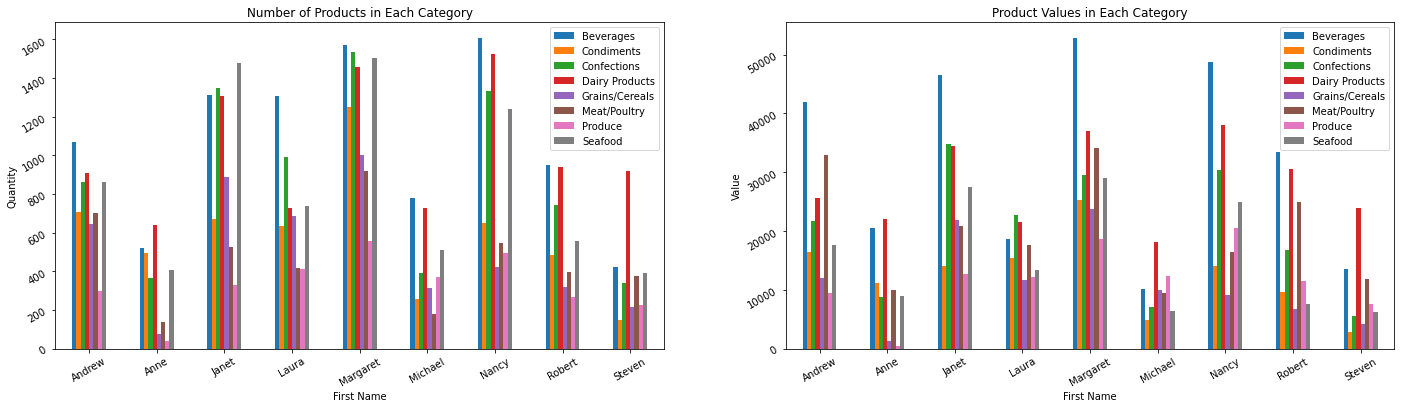

In [16]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create barplots
employee_cat_quantity_pivot.plot(kind='bar', ax=ax[0])
employee_cat_value_pivot.plot(kind='bar', ax=ax[1])
# Add labels
ax[0].set_title('Number of Products in Each Category')
ax[0].set_xlabel('First Name')
ax[0].set_ylabel('Quantity')
ax[0].tick_params(labelrotation=30)
ax[0].get_legend().set_title("")
ax[1].set_title('Product Values in Each Category')
ax[1].set_xlabel('First Name')
ax[1].set_ylabel('Value')
ax[1].tick_params(labelrotation=30)
ax[1].get_legend().set_title("")
# Show the image
plt.show()

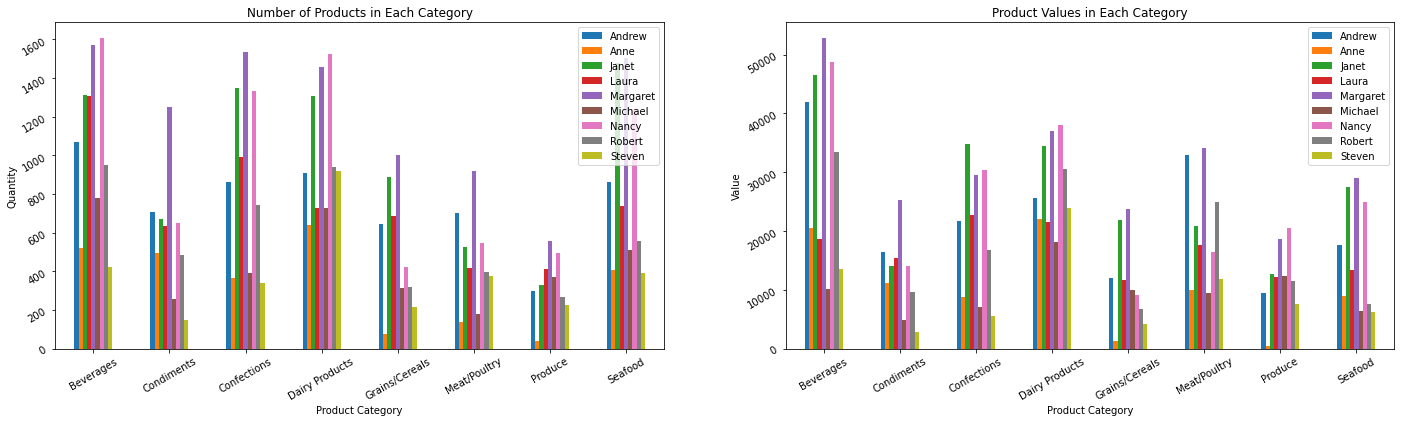

In [17]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create barplots
employee_cat_quantity_pivot.T.plot(kind='bar', ax=ax[0])
employee_cat_value_pivot.T.plot(kind='bar', ax=ax[1])
# Add labels
ax[0].set_title('Number of Products in Each Category')
ax[0].set_xlabel('Product Category')
ax[0].set_ylabel('Quantity')
ax[0].tick_params(labelrotation=30)
ax[0].get_legend().set_title("")
ax[1].set_title('Product Values in Each Category')
ax[1].set_xlabel('Product Category')
ax[1].set_ylabel('Value')
ax[1].tick_params(labelrotation=30)
ax[1].get_legend().set_title("")
# Show the image
plt.show()

### Employees & Customers

## Summary